In [2]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
import utils
from model01 import MLPModel01
from preprocess import prepare_data
from metrics import performance_report

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import keras
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_recall_curve, confusion_matrix

In [17]:
n_categories = 2 # implicit in prepare_data (maybe paraeterise)
lookahead = 1
window = 60

In [4]:
X_train, Y_train, prices_train = prepare_data(utils.load_1minute_fx_bars("USDJPY", 2009), lookahead=lookahead, window=window)

In [5]:
X_dev, Y_dev, prices_dev = prepare_data(utils.load_1minute_fx_bars("USDJPY", 2010)[:100000], lookahead=lookahead, window=window)

In [6]:
X_test, Y_test, prices_test = prepare_data(utils.load_1minute_fx_bars("USDJPY", 2010)[100000:200000], lookahead=lookahead, window=window)

In [7]:
print (X_train.shape)
n_features = X_train.shape[1]
print ("n_features:", n_features)

(343456, 243)
n_features: 243


In [8]:
# from sklearn.linear_model import SGDClassifier
# lin_model = SGDClassifier(loss='hinge', penalty='l2', n_iter=200, n_jobs=10)
# lin_model.fit(X_train.as_matrix(), Y_train)

# print( "train f1", f1_score(Y_train, lin_model.predict(X_train), average='weighted') )
# print( "test f1", f1_score(Y_test, lin_model.predict(X_test), average='weighted'))

In [9]:
# from sklearn.linear_model import LogisticRegression
# lr_model = LogisticRegression(n_jobs=10)
# lr_model.fit(X_train.as_matrix(), Y_train)

# print( "train f1", f1_score(Y_train, lr_model.predict(X_train), average='weighted') )
# print( "test f1", f1_score(Y_test, lr_model.predict(X_test), average='weighted'))

In [10]:
# from sklearn.ensemble import RandomForestClassifier
# rf_model = RandomForestClassifier(max_depth=5, n_jobs=12)
# rf_model.fit(X_train.as_matrix(), Y_train)

# print( "train f1", f1_score(Y_train, rf_model.predict(X_train), average='weighted') )
# print( "test f1", f1_score(Y_test, rf_model.predict(X_test), average='weighted'))

In [80]:
layer_widths = [1]
dropout = 0

In [81]:
model = MLPModel01(lookahead, n_features, n_categories, layer_widths, dropout)
print (model.summary())

compilation took: 0.1 seconds
Model id:  MLPModel01_20170302_2011_LA1_F243_C2_L1_DO0
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_72 (Dense)                 (None, 1)             244         dense_input_17[0][0]             
____________________________________________________________________________________________________
dense_73 (Dense)                 (None, 1)             2           dense_72[0][0]                   
Total params: 246
Trainable params: 246
Non-trainable params: 0
____________________________________________________________________________________________________
None


In [82]:
max_epochs = 200
hist = model.fit(
    X_train.as_matrix(), Y_train, 
    validation_data=(X_dev.as_matrix(),Y_dev), 
    max_epochs=max_epochs,
    es_patience=25)

Epoch 0, train_loss: 0.692 validation_loss 0.682
Epoch 1, train_loss: 0.684 validation_loss 0.680
Epoch 2, train_loss: 0.683 validation_loss 0.680
Epoch 3, train_loss: 0.682 validation_loss 0.678
Epoch 4, train_loss: 0.681 validation_loss 0.678
saved to  saves/MLPModel01_20170302_2011_LA1_F243_C2_L1_DO0-005-0.678.hdf5
Epoch 5, train_loss: 0.681 validation_loss 0.676
Epoch 6, train_loss: 0.680 validation_loss 0.679
Epoch 7, train_loss: 0.680 validation_loss 0.677
Epoch 8, train_loss: 0.680 validation_loss 0.676
Epoch 9, train_loss: 0.680 validation_loss 0.677
saved to  saves/MLPModel01_20170302_2011_LA1_F243_C2_L1_DO0-010-0.677.hdf5
Epoch 10, train_loss: 0.680 validation_loss 0.675
Epoch 11, train_loss: 0.680 validation_loss 0.677
Epoch 12, train_loss: 0.680 validation_loss 0.676
Epoch 13, train_loss: 0.680 validation_loss 0.675
Epoch 14, train_loss: 0.680 validation_loss 0.676
saved to  saves/MLPModel01_20170302_2011_LA1_F243_C2_L1_DO0-015-0.676.hdf5
Epoch 15, train_loss: 0.680 validat

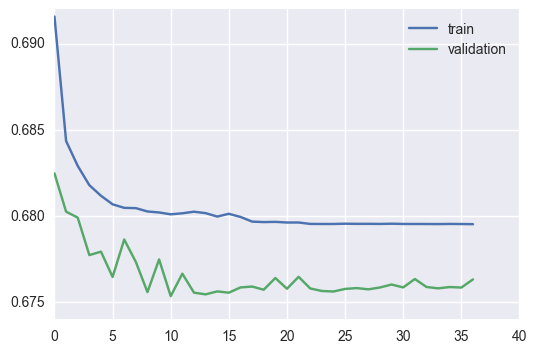

In [86]:
plt.plot(model.progress_callback.train_losses, label='train')
plt.plot(model.progress_callback.validation_losses, label='validation')
plt.legend();

In [87]:
Y_train_pred = model.predict(X_train.as_matrix(), batch_size=1024)
Y_train_pred_class = utils.prediction_to_category2(Y_train_pred)
Y_test_pred = model.predict(X_test.as_matrix(), batch_size=1024)
Y_test_pred_class = utils.prediction_to_category2(Y_test_pred)

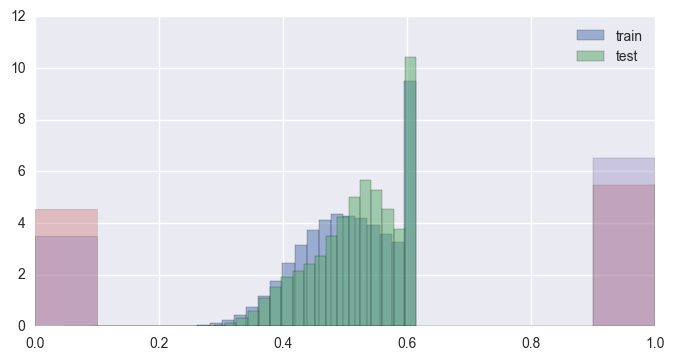

In [88]:
plt.figure(figsize=(8,4))
plt.hist(Y_train_pred, alpha=0.5, bins=30, normed=True, label='train')
plt.hist(Y_test_pred, alpha=0.5, bins=30, normed=True, label='test')
plt.hist(Y_train_pred_class, alpha=0.3, normed=True)
plt.hist(Y_test_pred_class, alpha=0.3, normed=True)
plt.legend()

------------------------------------------------------
train
f1-score: 0.571
             precision    recall  f1-score   support

          0       0.57      0.52      0.55    169201
          1       0.57      0.62      0.59    174255

avg / total       0.57      0.57      0.57    343456

------------------------------------------------------
test
f1-score: 0.575
             precision    recall  f1-score   support

          0       0.56      0.42      0.48     45473
          1       0.60      0.72      0.65     54527

avg / total       0.58      0.58      0.57    100000



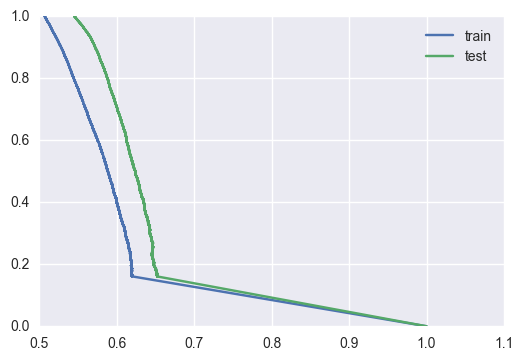

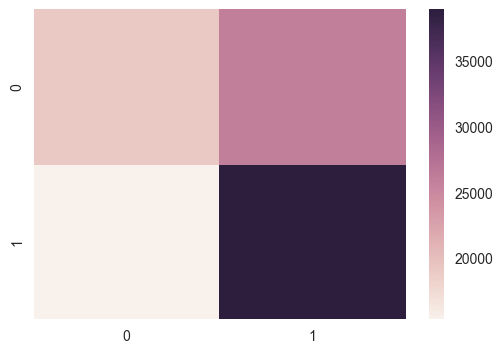

In [89]:
performance_report("train", prices_train, lookahead, Y_train, Y_train_pred_class)
performance_report("test",  prices_test,  lookahead, Y_test, Y_test_pred_class)

train_curve = precision_recall_curve(Y_train, Y_train_pred)
test_curve = precision_recall_curve(Y_test, Y_test_pred)

plt.plot(train_curve[0], train_curve[1], label='train')
plt.plot(test_curve[0], test_curve[1], label='test')
plt.legend()
plt.show()
sns.heatmap(confusion_matrix(Y_test, Y_test_pred_class))

dropout = 0  , lookahead = 1

| width | layers    | epochs | train | test |
| -----: | ---- :     | ---:    | ---:   | ---:  |
| 1     | 1         |  100   | .57   | .58  |
| 1     | 100       |  100   | .58   | .59  |
| 1     | 100       |  500   | .57   | .59  |
| 1     | 100 x 100 |  100 | .58   | .59  |
| 10    | 1         |  100 |  .57  | .59  |
| 10    | 10        |  100 |  .57  | .58  |
| 10    | 100       |  100 |  .58 | .58   |
| 10    | 100 x 100 |  100 |  .60 | .58   |
| 10    | 100 x 100 x 100 |  100 |  .62 | .57   |
| 10    | 100 x 100 x 100 x 100 |  100 |  .63 | .56   |
| 20    | 1 |  100 |  .56 | .58  |
| 20    | 100 |  100 | .58  | .58  |
| 40    | 100 |  500 x 500 x 500 | .60  | .61  |

Dropout = 0.1, lookahead = 1 

| width | layers    | epochs | train | test |
| -----: | ---- :     | ---:    | ---:   | ---:  |
| 10    | 100 x 100 x 100 x 100 |  100 | .60  | .58  |
| 10    | 100 x 100 x 100 x 100 |  200 | .62  | .58  |


Dropout = 0.2, lookahead = 1 

| width | layers    | epochs | train | test |
| -----: | ---- :     | ---:    | ---:   | ---:  |
| 10    | 100 x 100 x 100 x 100 |  100 | .59 | .59  |
| 10    | 100 x 100 x 100 x 100 |  200 | .60 | .58  |

Dropout = 0.5, lookeahead = 1

| width | layers    | epochs | train | test |
| -----: | ---- :     | ---:    | ---:   | ---:  |
| 60    | 500 x 500 x 500 x 500 |  200 | .64 | .62|
| 60    | 100 x 100 x 100 x 100 |  200 | .64 | .65




- .681 / .57 100^3 / LA:1, W:60
- .679 / .569 100^4


In [ ]:
print( len(Y_test) )
print( len(Y_test_pred_class) )
print( len(prices_test))
print( len(utils.future_return(prices_test, 1) ))

In [ ]:
i_s = []
mean_rets = []
for i in range(1,500,1):
    test_returns = utils.future_return(prices_test, i).fillna(0).values
    test_returns = test_returns - test_returns.mean()

    idx = np.zeros(len(test_returns))
    idx[Y_test_pred_class[:,0] == 0] = -1
    idx[Y_test_pred_class[:,0] == 1] = 1

    mean_ret = (test_returns * idx).mean() * 1e4
    mean_rets.append(mean_ret)
    i_s.append(i/60) #*24))
plt.plot(i_s, mean_rets,'.-')

In [ ]:
prices_test.plot()

In [ ]:
n_trade = 1000


In [ ]:
18000 / (60*24)